In [1]:
import sys
sys.path.append('../module')

from collections import defaultdict
import math

import numpy as np
import cupy as cp
import pandas as pd
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

from hdc import *

In [2]:
RNG = np.random.default_rng()

In [3]:
if cp.cuda.is_available():
# if cp.cuda.is_available() and False:
    xp = cp.get_array_module(cp.empty(1))
    xp_array_from_gpu = lambda a: a.get() if isinstance(a, cp.ndarray) else a
    xp_array_to_gpu = lambda a: cp.asarray(a) if isinstance(a, np.ndarray) else a
else:
    xp = cp.get_array_module(np.empty(1))
    xp_array_from_gpu = lambda a: a
    xp_array_to_gpu = lambda a: a
    
print(f'xp = {xp.__name__}')

xp = numpy


In [4]:
hdc = Hdc(10000, xp, dtype='f')
hdc.bundle = hdc.bundle_noties
COS_SIM_THRESHOLD = 0.055
HDIST_THRESHOLD = 4700

# hdc = Hdc(1000, xp, dtype='f')
# hdc.bundle = hdc.bundle_noties
# COS_SIM_THRESHOLD = 0.17
# HDIST_THRESHOLD = 410

# hdc = Hdc(2000, xp, dtype='f')
# hdc.bundle = hdc.bundle_noties
# COS_SIM_THRESHOLD = 0.11
# HDIST_THRESHOLD = 880

In [5]:
x1 = hdc()
x2 = hdc()
(x1 == x2).sum(), hdc.hdist(x1, x2), hdc.sim(x1, x2)

(np.int64(4947), 5053, np.float32(-0.0106))

In [6]:
for _ in range(1000):
    x1 = hdc()
    x2 = hdc()
    s = hdc.sim(x1, x2)
    assert s < COS_SIM_THRESHOLD
    h = hdc.hdist(x1, x2)
    assert h > HDIST_THRESHOLD
    assert np.isclose(hdc.normalize(x1) @ hdc.normalize(x2), s)

In [7]:
xs1 = hdc(10)
xs2 = hdc(10)
xs1_norm = hdc.normalize(xs1)
xs2_norm = hdc.normalize(xs2)

for i, x_pair in enumerate(zip(xs1, xs2)):
    s = hdc.sim(x_pair[0], x_pair[1])
    assert s < COS_SIM_THRESHOLD
    h = hdc.hdist(x_pair[0], x_pair[1])
    assert h > HDIST_THRESHOLD
    assert np.isclose(xs1_norm[i] @ xs2_norm[i], s)    

In [8]:
b = hdc.bundle_noties(x1, x2)
x1[:10], x2[:10], b[:10], hdc.hdist(x1, b), hdc.hdist(x2, b), hdc.sim(x1, b), hdc.sim(x2, b)

(array([-1., -1., -1.,  1., -1.,  1.,  1.,  1.,  1.,  1.], dtype=float32),
 array([ 1.,  1., -1., -1.,  1.,  1.,  1., -1., -1.,  1.], dtype=float32),
 array([ 0.,  0., -1.,  0.,  0.,  1.,  1.,  0.,  0.,  1.], dtype=float32),
 4974,
 4974,
 np.float32(0.7089429),
 np.float32(0.7089429))

In [9]:
for _ in range(1000):
    b = hdc.bundle_noties(x1, x2)
    assert hdc.sim(x1, b) > COS_SIM_THRESHOLD
    assert hdc.sim(x2, b) > COS_SIM_THRESHOLD

In [10]:
b = hdc.bundle_ties(x1, x2)
x1[:10], x2[:10], b[:10], hdc.hdist(x1, b), hdc.hdist(x2, b),hdc.sim(x1, b), hdc.sim(x2, b)

(array([-1., -1., -1.,  1., -1.,  1.,  1.,  1.,  1.,  1.], dtype=float32),
 array([ 1.,  1., -1., -1.,  1.,  1.,  1., -1., -1.,  1.], dtype=float32),
 array([-1.,  1., -1.,  1., -1.,  1.,  1., -1., -1.,  1.], dtype=float32),
 2503,
 2471,
 np.float32(0.4994),
 np.float32(0.5058))

In [11]:
for _ in range(1000):
    b = hdc.bundle_ties(x1, x2)
    assert hdc.sim(x1, b) > COS_SIM_THRESHOLD
    assert hdc.sim(x2, b) > COS_SIM_THRESHOLD
    assert hdc.hdist(x1, b) < HDIST_THRESHOLD
    assert hdc.hdist(x2, b) < HDIST_THRESHOLD

In [12]:
assert hdc.sim(x1, hdc.bundle_noties(x1, x2)) > COS_SIM_THRESHOLD

In [13]:
b = hdc.bind(x1, x2)
x1[:10], x2[:10], b[:10], hdc.hdist(x1, b), hdc.hdist(x2, b), hdc.hdist(x1, x2), hdc.sim(x1, b), hdc.sim(x2, b)

(array([-1., -1., -1.,  1., -1.,  1.,  1.,  1.,  1.,  1.], dtype=float32),
 array([ 1.,  1., -1., -1.,  1.,  1.,  1., -1., -1.,  1.], dtype=float32),
 array([-1., -1.,  1., -1., -1.,  1.,  1., -1., -1.,  1.], dtype=float32),
 4952,
 4992,
 4974,
 np.float32(0.0096),
 np.float32(0.0016))

In [14]:
for _ in range(1000):
    b = hdc.bind(x1, x2)
    assert hdc.sim(x1, b) < COS_SIM_THRESHOLD
    assert hdc.sim(x2, b) < COS_SIM_THRESHOLD

In [15]:
s = hdc.shift(x1)
x1[:10], s[:10], hdc.hdist(x1, s), hdc.sim(x1, s)

(array([-1., -1., -1.,  1., -1.,  1.,  1.,  1.,  1.,  1.], dtype=float32),
 array([ 1., -1., -1., -1.,  1., -1.,  1.,  1.,  1.,  1.], dtype=float32),
 4972,
 np.float32(0.0056))

In [16]:
for _ in range(1000):
    s = hdc.shift(x1)
    assert hdc.sim(x1, s) < COS_SIM_THRESHOLD

In [17]:
m = hdc(3)
m[:,:10], hdc.bundle_noties(m)[:10]

(array([[ 1.,  1., -1.,  1.,  1.,  1.,  1., -1.,  1.,  1.],
        [-1., -1.,  1., -1., -1.,  1., -1., -1., -1.,  1.],
        [ 1.,  1., -1., -1., -1.,  1.,  1.,  1.,  1.,  1.]], dtype=float32),
 array([ 1.,  1., -1., -1., -1.,  1.,  1., -1.,  1.,  1.], dtype=float32))

In [18]:
for _ in tqdm(range(128*128)):
    xs = hdc(3)
    x1 = xs[0]
    x2 = xs[1]
    x3 = xs[2]
    assert np.array_equal(hdc.bind(x1, hdc.bundle_noties(x2, x3)), hdc.bundle_noties(hdc.bind(x1, x2), hdc.bind(x1, x3)))
    assert np.isclose(hdc.sim(x1, x2), hdc.sim(hdc.bind(x1, x3), hdc.bind(x2, x3)))
    assert np.isclose(hdc.sim(x1, x2), hdc.sim(hdc.shift(x1), hdc.shift(x2)))

  0%|          | 0/16384 [00:00<?, ?it/s]

In [19]:
x1 = hdc()
bundle = hdc.bundle([x1])
assert np.array_equal(x1, bundle)

In [20]:
bipolar_hdv = hdc()
binary_hdv = hdc.to_binary(bipolar_hdv)
assert np.array_equal(hdc.to_bipolar(binary_hdv), bipolar_hdv)

In [21]:
hdvs = hdc(4)
bipolar_bundle = hdc.bundle(hdvs)
print(list(map(lambda hdv: hdc.sim(hdv, bipolar_bundle), hdvs)))
binary_bundle = hdc.to_binary(bipolar_bundle)
assert not np.array_equal(bipolar_bundle, binary_bundle)
assert not np.array_equal(bipolar_bundle, hdc.to_bipolar(binary_bundle))
assert hdc.sim(hdvs[0], hdc.to_bipolar(binary_bundle)) > COS_SIM_THRESHOLD
print(list(map(lambda hdv: hdc.sim(hdv, hdc.to_bipolar(binary_bundle)), hdvs)))

[np.float32(0.4797424), np.float32(0.4850546), np.float32(0.4751891), np.float32(0.46962392)]
[np.float64(0.3838), np.float64(0.3814), np.float64(0.3684), np.float64(0.3762)]


In [22]:
hdvs = hdc(5)
bipolar_bundle = hdc.bundle(hdvs)
binary_bundle = hdc.to_binary(bipolar_bundle)
assert not np.array_equal(bipolar_bundle, binary_bundle)
assert np.array_equal(bipolar_bundle, hdc.to_bipolar(binary_bundle))

In [23]:
hdv1 = hdc.normalize(hdc())
hist = None
trials = 100

for _ in tqdm(range(trials)):
    other_hdvs = hdc.normalize(hdc(10000))
    cos_sims = other_hdvs @ hdv1
    cos_sims *= 100
    h = np.histogram(cos_sims, bins=list(range(-20, 20 + 1, 1)))
    hist = h[0] if hist is None else hist + h[0]

  0%|          | 0/100 [00:00<?, ?it/s]

In [24]:
df = pd.DataFrame(columns=['Range', 'Count', '%'])
df['Range'] = list(map(lambda pair: f'{pair[0]:6.2f}, {pair[1]:6.2f}', (zip(h[1]/100, h[1][1:]/100))))
df['Count'] = xp_array_from_gpu(hist)
df['%'] = list(map(lambda p: f'{p*100:.4f}%', hist / (np.sum(hist))))
df

,Range,Count,%
0,"-0.20, -0.19",0,0.0000%
1,"-0.19, -0.18",0,0.0000%
2,"-0.18, -0.17",0,0.0000%
3,"-0.17, -0.16",0,0.0000%
4,"-0.16, -0.15",0,0.0000%
5,"-0.15, -0.14",0,0.0000%
6,"-0.14, -0.13",0,0.0000%
7,"-0.13, -0.12",0,0.0000%
8,"-0.12, -0.11",0,0.0000%
9,"-0.11, -0.10",0,0.0000%


In [25]:
hdv1 = hdc()
hist = None
trials = 100
bin_step = hdc.N // 200
bins = list(range(hdc.N // 2 - bin_step * 25, hdc.N // 2 + bin_step * 25, bin_step))

for _ in tqdm(range(trials)):
    other_hdvs = hdc(10000)
    hdists = np.count_nonzero(hdv1 != other_hdvs, axis=1)
    h = np.histogram(hdists, bins=bins)
    hist = h[0] if hist is None else hist + h[0]

  0%|          | 0/100 [00:00<?, ?it/s]

In [26]:
df = pd.DataFrame(columns=['Range', 'Count', '%'])
df['Range'] = list(map(lambda pair: f'{pair[0]} - {pair[1]}', (zip(h[1], h[1][1:]))))
df['Count'] = xp_array_from_gpu(hist)
df['%'] = list(map(lambda p: f'{p*100:.4f}%', hist / (np.sum(hist))))
df

,Range,Count,%
0,3750 - 3800,0,0.0000%
1,3800 - 3850,0,0.0000%
2,3850 - 3900,0,0.0000%
3,3900 - 3950,0,0.0000%
4,3950 - 4000,0,0.0000%
5,4000 - 4050,0,0.0000%
6,4050 - 4100,0,0.0000%
7,4100 - 4150,0,0.0000%
8,4150 - 4200,0,0.0000%
9,4200 - 4250,0,0.0000%


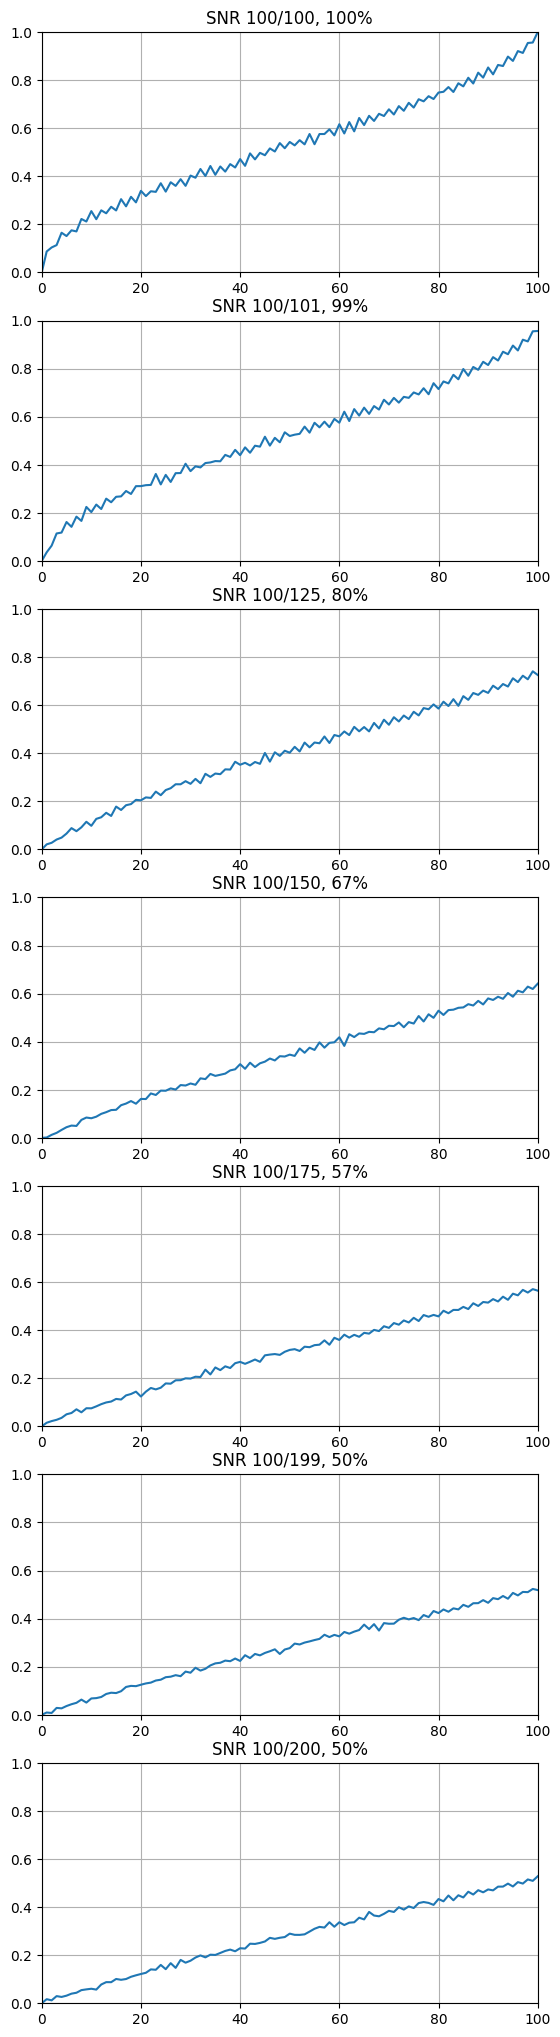

In [27]:
signal_hdvs = hdc(100)
signal_points = list(range(0, signal_hdvs.shape[0] + 1))
bundle = hdc.bundle(signal_hdvs)

noise_hdvs = hdc(100)
noise_points = [0, 1, 25, 50, 75, 99, 100]

values = []

for noise_hdv_count in noise_points:
    noise_hdv_indices = RNG.choice(noise_hdvs.shape[0], noise_hdv_count, replace=False)
    noise_level_values = []
    
    for signal_hdv_count in signal_points:
        if signal_hdv_count == 0:
            noise_level_values.append(0)
            continue
            
        signal_hdv_indices = RNG.choice(signal_hdvs.shape[0], signal_hdv_count, replace=False)
        b = hdc.bundle(list(noise_hdvs[noise_hdv_indices]) + list(signal_hdvs[signal_hdv_indices]))
        sim = hdc.sim(bundle, b)
        noise_level_values.append(xp_array_from_gpu(sim))

    values.append(noise_level_values)

fig, ax = plt.subplots(len(noise_points)) 
fig.set_figheight(fig.get_figwidth() * 4)

for x in range(len(noise_points)):
    ax[x].set_ylim(0, 1)
    ax[x].set_xlim(0, max(signal_points))
    ax[x].grid()
    ax[x].plot(signal_points, values[x])
    ax[x].set_title(f'SNR {len(signal_hdvs)}/{len(signal_hdvs)+noise_points[x]}, {len(signal_hdvs)/(len(signal_hdvs)+noise_points[x])*100:.0f}%')
    
plt.show()

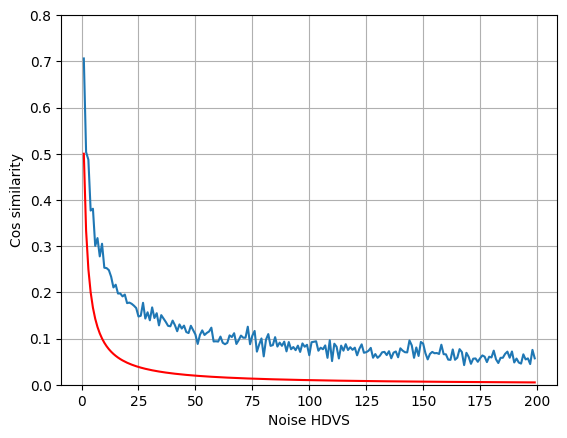

In [28]:
signal_hdv = hdc()
points = list(range(1, 200))
values = []
theoretical_snr = []

for x in points:
    noise_hdvs = hdc(x + 1)[:x]
    b = hdc.bundle([signal_hdv] + list(noise_hdvs))
    sim = hdc.sim(signal_hdv, b)
    values.append(xp_array_from_gpu(sim))
    theoretical_snr.append(1/(1+x))

#plt.bar(points, values)
plt.plot(points, values)
plt.xlabel('Noise HDVS')
plt.ylabel('Cos similarity')
#ax2 = plt.gca().twinx()
#ax2.plot(points, theoretical_snr, '-r')
plt.plot(points, theoretical_snr, '-r')
plt.ylim(0, 0.8)
plt.grid()
plt.show()

In [29]:
x1 = hdc()
x2 = hdc()
bundle = hdc.bundle(x1, x2)
z = hdc.debundle(bundle, x2)
hdc.sim(z, x1), hdc.sim(z, x2)

(np.float32(0.7033491), np.float32(-0.7033491))

In [30]:
x1 = hdc()
x2 = hdc()
x3 = hdc()

bundle1 = hdc.bundle(x1, x2, x3)
bundle2 = hdc.bundle(hdc.bundle(x1, x2), x3)
assert not np.array_equal(bundle1, bundle2)
hdc.sim(x1, bundle1), hdc.sim(x2, bundle1), hdc.sim(x3, bundle1), hdc.sim(x1, bundle2), hdc.sim(x2, bundle2), hdc.sim(x3, bundle2)

(np.float32(0.5252),
 np.float32(0.4936),
 np.float32(0.4886),
 np.float32(0.31238112),
 np.float32(0.2757531),
 np.float32(0.86272824))

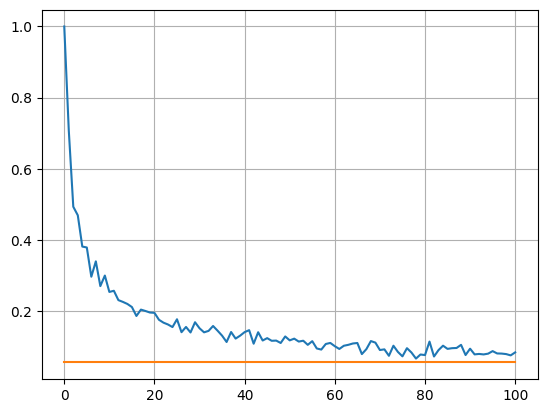

In [31]:
source = hdc()
target = hdc()
map_hdc = hdc.bind(source, target)
source_mapped = hdc.bind(source, map_hdc)
assert np.isclose(hdc.sim(source_mapped, target), 1)

noise_levels = range(0, 100 + 1)
sim_values = []

for noise_level in noise_levels:
    noise = hdc(noise_level)
    source_noise = hdc.bundle(xp.vstack([source, noise]))
    source_noise_mapped = hdc.bind(source_noise, map_hdc)
    sim = xp_array_from_gpu(hdc.sim(source_noise_mapped, target))
    sim_values.append(sim)

plt.plot(noise_levels, sim_values)
plt.plot([0, 100], [COS_SIM_THRESHOLD, COS_SIM_THRESHOLD])
plt.grid()
plt.show()

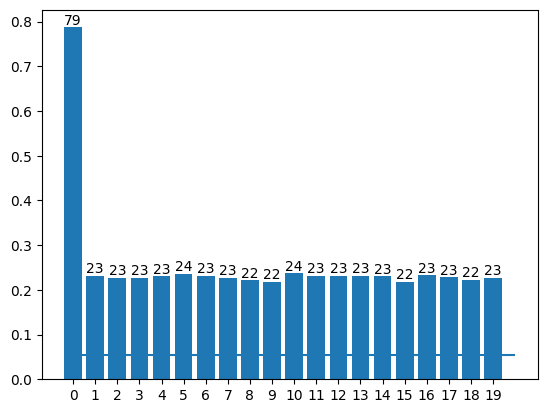

In [32]:
source = hdc()
source_population = None

for i in range(20):
    noise = hdc(3)
    source_noise =  hdc.bundle(xp.vstack([source, noise]))
    arrays_to_stack = [source_population] if not source_population is None else []
    arrays_to_stack.append(source_noise)
    source_population = xp.vstack(arrays_to_stack)

target = hdc()
map_hdc = hdc.bind(target, source_population[0])
sims = []

for i in range(source_population.shape[0]):
    sim = xp_array_from_gpu(hdc.sim(target, hdc.bind(source_population[i], map_hdc)))
    sims.append(sim)

b = plt.bar(list(map(str, range(source_population.shape[0]))), sims)
plt.bar_label(b, list(map(lambda s: f'{s*100:.0f}', sims)))
plt.hlines(COS_SIM_THRESHOLD, 0, source_population.shape[0])
plt.show()

In [33]:
x_source = hdc()
x_source_population = None

for i in range(10):
    noise = hdc(50)
    x_source_noise =  hdc.bundle(xp.vstack([x_source, noise]))
    arrays_to_stack = [x_source_population] if not x_source_population is None else []
    arrays_to_stack.append(x_source_noise)
    x_source_population = xp.vstack(arrays_to_stack)

x_target = hdc()
mappings = None
df_stats = pd.DataFrame(columns=['att_no'] + list(map(lambda q: f'm_{q:02}', range(x_source_population.shape[0]))))

for att_no in range(10):
    m_vals = [0] * x_source_population.shape[0]
    
    for i in range(x_source_population.shape[0]):
        x = x_source_population[i]
        new_mapping = hdc.bind(x, x_target)
        
        if mappings is None:
            mappings = xp.vstack([new_mapping])
        else:
            nothing_found = True
            
            for m_i, mapping in enumerate(mappings):
                y = hdc.bind(x, mapping)
                sim = hdc.sim(y, x_target)
    
                if sim >= COS_SIM_THRESHOLD:
                    mapping[:] = hdc.bundle(mapping, new_mapping)
                    nothing_found = False
                    m_vals[m_i] += 1
                    
            if nothing_found:
                mappings = xp.vstack([mappings, new_mapping])

    df_stats.loc[len(df_stats)] = [att_no] + m_vals

df_stats

,att_no,m_00,m_01,m_02,m_03,m_04,m_05,m_06,m_07,m_08,m_09
0,0,0,0,0,0,0,0,0,0,0,0
1,1,1,1,1,1,1,1,1,1,1,1
2,2,1,1,1,1,1,1,1,1,1,1
3,3,1,1,1,1,1,1,1,1,1,1
4,4,1,1,1,1,1,1,1,1,1,1
5,5,1,1,1,1,1,1,1,1,1,1
6,6,1,1,1,1,1,1,1,1,1,1
7,7,1,1,1,1,1,1,1,1,1,1
8,8,1,1,1,1,1,1,1,1,1,1
9,9,1,1,1,1,1,1,1,1,1,1


In [34]:
#mappings[0] = hdc.bundle(mappings[0], mappings[1], mappings[2])
mappings[0] = hdc.bundle(mappings)

df_stats = pd.DataFrame(columns=list(map(lambda q: f'm_{q:02}', range(x_source_population.shape[0]))))

for i in range(x_source_population.shape[0]):
    df_stats.loc[f'sample_{i}'] = [0.0] * x_source_population.shape[0]

for i in range(x_source_population.shape[0]):
    x = x_source_population[i]
        
    for m_i, mapping in enumerate(mappings):
        y = hdc.bind(x, mapping)
        sim = hdc.sim(y, x_target)

        # if sim >= COS_SIM_THRESHOLD:
        df_stats.loc[f'sample_{i}', f'm_{m_i:02}'] = sim

df_stats

,m_00,m_01,m_02,m_03,m_04,m_05,m_06,m_07,m_08,m_09
sample_0,0.301175,0.0094,0.0230,0.0268,0.0230,0.0092,0.0172,0.0220,0.0154,-0.0088
sample_1,0.293674,1.0000,0.0228,0.0278,0.0140,0.0070,0.0030,0.0146,0.0056,0.0130
sample_2,0.314131,0.0228,1.0000,0.0062,0.0112,0.0262,0.0186,0.0214,0.0172,0.0218
sample_3,0.309358,0.0278,0.0062,1.0000,0.0198,0.0204,0.0108,0.0068,0.0050,0.0268
sample_4,0.309131,0.0140,0.0112,0.0198,1.0000,0.0142,0.0054,0.0278,0.0208,0.0102
sample_5,0.308676,0.0070,0.0262,0.0204,0.0142,1.0000,0.0172,0.0260,0.0054,0.0200
sample_6,0.285719,0.0030,0.0186,0.0108,0.0054,0.0172,1.0000,0.0088,-0.0070,0.0076
sample_7,0.305721,0.0146,0.0214,0.0068,0.0278,0.0260,0.0088,1.0000,0.0138,0.0112
sample_8,0.290492,0.0056,0.0172,0.0050,0.0208,0.0054,-0.0070,0.0138,1.0000,0.0278
sample_9,0.295947,0.0130,0.0218,0.0268,0.0102,0.0200,0.0076,0.0112,0.0278,1.0000


In [35]:
mappings_norm = hdc.normalize(mappings)
mappings_norm_cross = xp_array_from_gpu(mappings_norm @ mappings_norm.T)
mappings_norm_cross[mappings_norm_cross < COS_SIM_THRESHOLD] = 0
pd.DataFrame(mappings_norm_cross)

,0,1,2,3,4,5,6,7,8,9
0,0.999999,0.293675,0.314132,0.309358,0.309131,0.308676,0.285719,0.305722,0.290492,0.295948
1,0.293675,0.999999,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.314132,0.000000,0.999999,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.309358,0.000000,0.000000,0.999999,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.309131,0.000000,0.000000,0.000000,0.999999,0.000000,0.000000,0.000000,0.000000,0.000000
5,0.308676,0.000000,0.000000,0.000000,0.000000,0.999999,0.000000,0.000000,0.000000,0.000000
6,0.285719,0.000000,0.000000,0.000000,0.000000,0.000000,0.999999,0.000000,0.000000,0.000000
7,0.305722,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.999999,0.000000,0.000000
8,0.290492,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.999999,0.000000
9,0.295948,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.999999


In [36]:
x1 = hdc()
z1 = hdc.zero()
zs = hdc.zero(10)
assert np.isnan(hdc.sim(x1, z1))

for z in zs:
    assert np.isnan(hdc.sim(x1, z))
    assert np.isnan(hdc.sim(z1, z))

/home/misha/dev/mine/neurovision/mnist_recognition/test/../module/hdc.py:128: RuntimeWarning: invalid value encountered in scalar divide
  return hdv1.astype('f') @ hdv2.astype('f') / (self.xp.linalg.norm(hdv1) * self.xp.linalg.norm(hdv2)) # .astype('f') is a MUST, otherwise Geisenbugs with overflow may occur


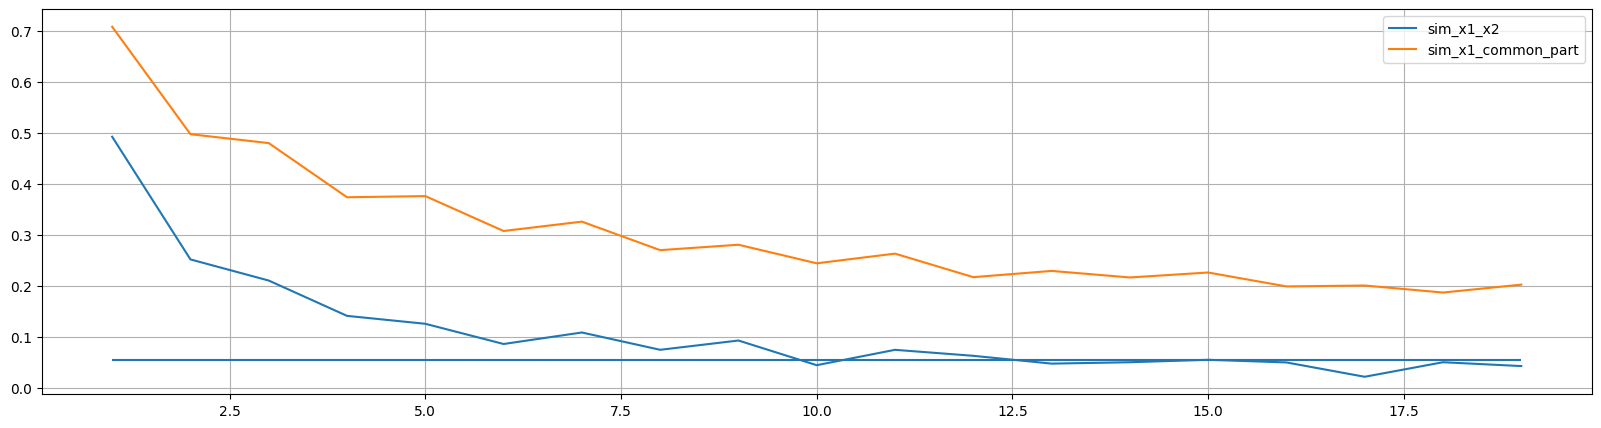

,noise_comps,sim_x1_x2,sim_x1_common_part,hdist_x1_x2,hdist_x1_common_part,hdist_x1_x2_is_close,hdist_x1_common_part_is_close
0,1,0.492803,0.708661,5070.0,4978.0,False,False
1,2,0.252000,0.497800,3740.0,2511.0,True,True
2,3,0.210543,0.480324,6035.0,4992.0,False,False
3,4,0.141200,0.374000,4294.0,3130.0,True,True
4,5,0.125668,0.376314,6258.0,5003.0,False,False
5,6,0.086000,0.307800,4570.0,3461.0,True,True
6,7,0.108583,0.326181,6202.0,5006.0,False,False
7,8,0.074600,0.270200,4627.0,3649.0,True,True
8,9,0.092820,0.280842,6189.0,4995.0,False,False
9,10,0.044400,0.244400,4778.0,3778.0,False,True


In [37]:
common_part = hdc(1)
df = pd.DataFrame(columns=['noise_comps', 'sim_x1_x2', 'sim_x1_common_part', 'hdist_x1_x2', 'hdist_x1_common_part'])

for i in range(1, common_part.shape[0] * 10 + 10):
    x1_raw = hdc(i)
    x1_raw = np.vstack([x1_raw, common_part])
    x1 = hdc.bundle(x1_raw)
    # x1 = hdc.bundle_ties(x1_raw) # good for hdist

    x2_raw = hdc(i)
    x2_raw = np.vstack([x2_raw, common_part])
    x2 = hdc.bundle(x2_raw)
    # x2 = hdc.bundle_ties(x2_raw) # good for hdist

    df.loc[len(df)] = [i, float(hdc.sim(x1, x2)), float(hdc.sim(x1, hdc.bundle(common_part))), float(hdc.hdist(x1, x2)), float(hdc.hdist(x1,  hdc.bundle(common_part)))]

df.noise_comps = df.noise_comps.astype(int)
df['hdist_x1_x2_is_close'] = df.hdist_x1_x2 < 4700
df['hdist_x1_common_part_is_close'] = df.hdist_x1_common_part < 4700
plt.figure(figsize=(20,5))
plt.plot(df.noise_comps, df['sim_x1_x2'], label='sim_x1_x2')
plt.plot(df.noise_comps, df['sim_x1_common_part'], label='sim_x1_common_part')
plt.hlines(COS_SIM_THRESHOLD, df.noise_comps.min(), df.noise_comps.max())
plt.grid()
plt.legend()
plt.show()

df

In [38]:
common_part = hdc(1)
assert np.array_equal(hdc.bundle(common_part), common_part[0])

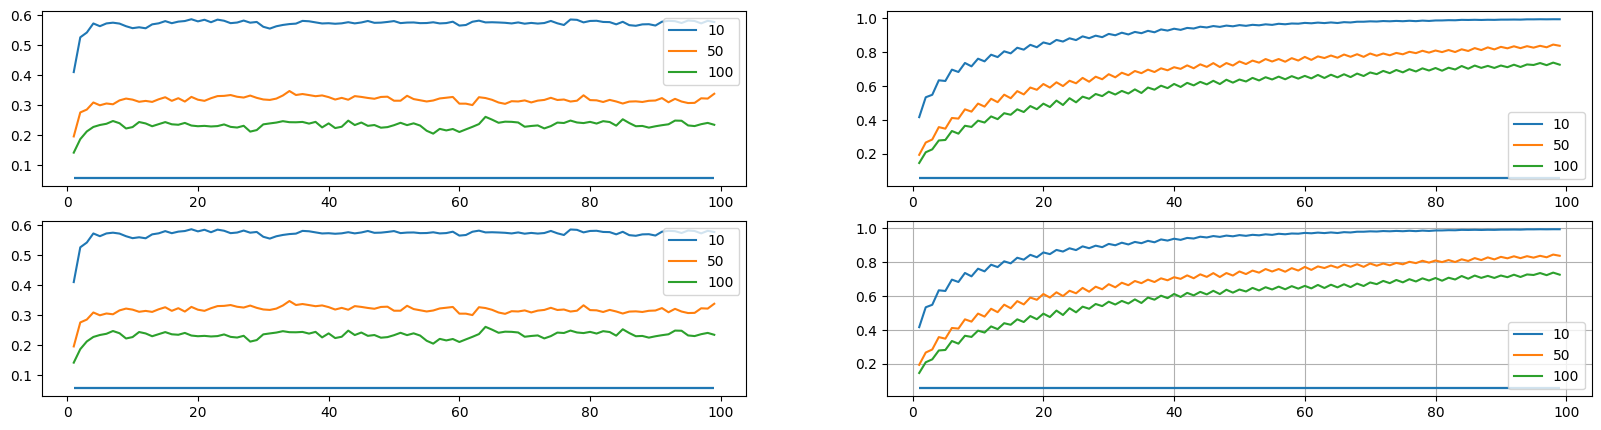

In [39]:
pure_signal = hdc(5)
dfs_capped = defaultdict(lambda: pd.DataFrame(columns=['distil_cycle', 'sim']))
dfs_uncapped = defaultdict(lambda: pd.DataFrame(columns=['distil_cycle', 'sim']))
distil_cycles = 100

# capped version
for noise_comps in [10, 50, 100]:
    distil_bundle = None

    for i in range(1, distil_cycles):
        x1_raw = hdc(noise_comps)
        x1_raw = np.vstack([x1_raw, pure_signal])
        x1 = hdc.bundle(x1_raw)
    
        distil_bundle = x1 if distil_bundle is None else hdc.bundle(distil_bundle, x1)

        df = dfs_capped[noise_comps]
        df.loc[len(df)] = [i, float(hdc.sim(distil_bundle, hdc.bundle(pure_signal)))]

# uncapped version
for noise_comps in [10, 50, 100]:
    x1s = []
    
    for i in range(1, distil_cycles):
        x1_raw = hdc(noise_comps)
        x1_raw = np.vstack([x1_raw, pure_signal])
        x1 = hdc.bundle(x1_raw)
        x1s.append(x1)

        distil_bundle = hdc.bundle(x1s)
        
        df = dfs_uncapped[noise_comps]
        df.loc[len(df)] = [i, float(hdc.sim(distil_bundle, hdc.bundle(pure_signal)))]

plt.figure(figsize=(20,5))

for i, dfs in enumerate([dfs_capped, dfs_uncapped]):
    plt.subplot(2, 2, i + 1)
    
    for noise_comps, df in dfs.items():
        df.distil_cycle = df.distil_cycle.astype(int)
        plt.plot(df.distil_cycle, df['sim'], label=f'{noise_comps}')
        plt.hlines(COS_SIM_THRESHOLD, df.distil_cycle.min(), df.distil_cycle.max())
        plt.legend(loc='best')

    plt.subplot(2, 2, i + 3)
    
    for noise_comps, df in dfs.items():
        df.distil_cycle = df.distil_cycle.astype(int)
        plt.plot(df.distil_cycle, df['sim'], label=f'{noise_comps}')
        plt.hlines(COS_SIM_THRESHOLD, df.distil_cycle.min(), df.distil_cycle.max())
        plt.legend(loc='best')

plt.grid()
plt.show()


In [40]:
pure_signal = hdc(5)
pure_signal_bundle = hdc.bundle(pure_signal)
distil_cycles = 100
hdvs = []
hdvs_01 = []

# HDC BUNDLING
for i in range(distil_cycles):
    noise_hdvs = hdc(50)
    hdv = np.vstack([noise_hdvs, pure_signal])
    hdv = hdc.bundle(hdv)
    hdvs.append(hdv)
    hdv_01 = hdv.copy()
    hdv_01[hdv_01 == -1] = 0
    hdvs_01.append(hdv_01)
    
distil_bundle = hdc.bundle(hdvs)

# HEBB PRINCIPAL COMPONENTS (PC)
# for prune_factor in [56]:
# for nu in tqdm(range(1, 100)):
pc_mask = xp.ones(hdc.N)
pc_counters = xp.ones(hdc.N)
nu = 0.01
# nu = nu / 100

for epoch in range(100):
    for hdv_01 in hdvs_01:
        x = hdv_01 * pc_mask
        y = hdv_01 @ pc_counters
    
        nomin = pc_counters + x * (nu * y)
        denom = nomin.max()
        pc_counters = (nomin / denom)

        # nomin = pc_counters + x * (nu * y)
        # denom = np.linalg.norm(pc_counters + x * (nu * y))
        # pc_counters = nomin / denom
    
    # Pruning
    pc_mask = (pc_counters >= np.max(pc_counters) * 56 / 100)
    pc_counters = pc_counters * pc_mask
    
    nu *= 0.9

pc_mask = pc_mask.astype('b')
hdc.sim(distil_bundle, pure_signal_bundle), hdc.sim(pc_mask, pure_signal_bundle), hdc.sim(distil_bundle, pc_mask)

(np.float32(0.85903645),
 np.float64(0.4494378736948008),
 np.float64(0.4896887610642677))

  0%|          | 0/400 [00:00<?, ?it/s]

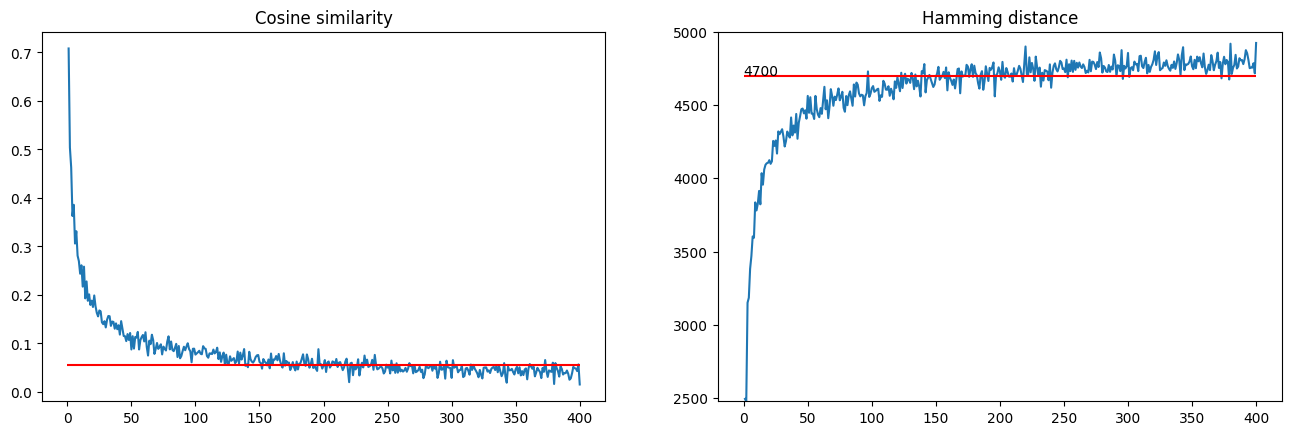

In [41]:
signal = hdc()
columns = defaultdict(list)
tie_breaker = hdc()

for i in tqdm(range(1, 400 + 1), leave=False):
    noise = hdc(i)
    bundle = hdc.bundle_noties(np.vstack([signal, noise]))
    columns['noise_comps'].append(i)
    columns['signal_to_bundle_sim'].append(hdc.sim(signal, bundle)) # cosine similarity
    bundle = xp.where(bundle == 0, tie_breaker, bundle)
    columns['signal_to_bundle_hd'].append(hdc.hdist(signal, bundle)) # hamming distance

df = pd.DataFrame(columns)
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_figwidth(16)

ax1.set_title('Cosine similarity')
ax1.plot(df.noise_comps, df.signal_to_bundle_sim)
ax1.hlines(COS_SIM_THRESHOLD, 0, df.noise_comps.max(), color='r')

ax2.set_title('Hamming distance')
ax2.plot(df.noise_comps, df.signal_to_bundle_hd)
ax2.set_ylim(xp.min(df.signal_to_bundle_hd), hdc.N // 2)
ax2.hlines(HDIST_THRESHOLD, 0, df.noise_comps.max(), color='r')
ax2.annotate(str(HDIST_THRESHOLD), xy=(0, HDIST_THRESHOLD));

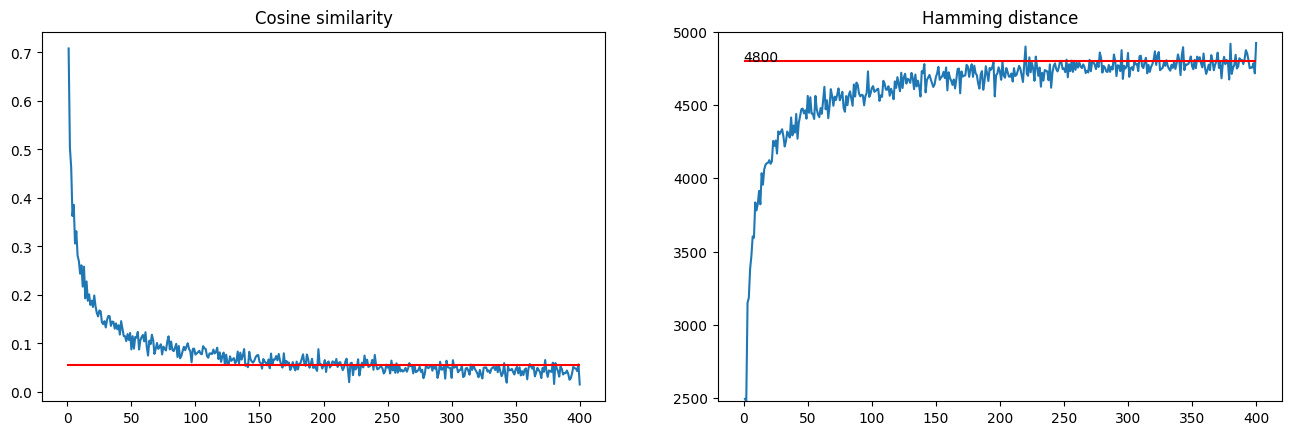

In [42]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_figwidth(16)

ax1.set_title('Cosine similarity')
ax1.plot(df.noise_comps, df.signal_to_bundle_sim)
ax1.hlines(COS_SIM_THRESHOLD, 0, df.noise_comps.max(), color='r')

ax2.set_title('Hamming distance')
ax2.plot(df.noise_comps, df.signal_to_bundle_hd)
ax2.set_ylim(xp.min(df.signal_to_bundle_hd), hdc.N // 2)
# ax2.hlines(HDIST_THRESHOLD, 0, df.noise_comps.max(), color='r')
# ax2.annotate(str(HDIST_THRESHOLD), xy=(0, HDIST_THRESHOLD));

ax2.hlines(5000 - 50 * 4, 0, df.noise_comps.max(), color='r')
ax2.annotate(str(5000 - 50 * 4), xy=(0, 5000 - 50 * 4));

In [43]:
columns = defaultdict(list)
thres_list = (0.05 + np.arange(12) * 0.01)

for N in tqdm(range(1000, 10000 + 1000, 1000)):
# for N in tqdm(range(1000, 2000, 1000)):
    hdc_n = Hdc(N, xp, dtype='f')
    columns['N'].append(N)

    signal = hdc_n()
    signal_norm = hdc_n.normalize(signal)
    others = hdc_n.normalize(hdc_n(100_000))
    cos_sims = others @ signal_norm

    for thres in thres_list:
        matches_count = (cos_sims > thres).sum()
        # probability (in %) to meet similar signal at random for given thres
        prob = 100 * (matches_count / others.shape[0])

        # Number of signals a hdv bundle can carry at given thres
        capacities = []
        
        for _ in range(10):
            for i in range(1, 200 + 1):
                capacity = i
                others2 = hdc_n(i)
                bundle = hdc_n.bundle_noties(np.vstack([signal, others2]))
                
                if hdc_n.sim(signal, bundle) < thres:
                    break
            
            capacities.append(capacity)

        columns[f'{thres:.2f}'].append(f'{prob:.4f}% / {np.array(capacities).mean().astype(int)}')

  0%|          | 0/10 [00:00<?, ?it/s]

In [44]:
pd.DataFrame(columns)

,N,0.05,0.06,0.07,0.08,0.09,0.10,0.11,0.12,0.13,0.14,0.15,0.16
0,1000,5.9850% / 71,3.0220% / 62,1.4370% / 53,0.5950% / 47,0.2300% / 40,0.0850% / 34,0.0270% / 31,0.0090% / 24,0.0020% / 24,0.0000% / 23,0.0000% / 23,0.0000% / 19
1,2000,1.2660% / 88,0.3660% / 65,0.0920% / 56,0.0190% / 55,0.0030% / 49,0.0000% / 39,0.0000% / 36,0.0000% / 33,0.0000% / 30,0.0000% / 25,0.0000% / 23,0.0000% / 21
2,3000,0.3390% / 110,0.0610% / 83,0.0100% / 70,0.0010% / 60,0.0000% / 50,0.0000% / 47,0.0000% / 39,0.0000% / 34,0.0000% / 28,0.0000% / 26,0.0000% / 25,0.0000% / 22
3,4000,0.0710% / 115,0.0050% / 94,0.0000% / 77,0.0000% / 60,0.0000% / 52,0.0000% / 47,0.0000% / 41,0.0000% / 36,0.0000% / 30,0.0000% / 29,0.0000% / 24,0.0000% / 22
4,5000,0.0180% / 116,0.0010% / 98,0.0000% / 79,0.0000% / 66,0.0000% / 59,0.0000% / 48,0.0000% / 42,0.0000% / 36,0.0000% / 31,0.0000% / 30,0.0000% / 26,0.0000% / 23
5,6000,0.0090% / 133,0.0000% / 110,0.0000% / 89,0.0000% / 66,0.0000% / 57,0.0000% / 52,0.0000% / 42,0.0000% / 38,0.0000% / 31,0.0000% / 30,0.0000% / 26,0.0000% / 24
6,7000,0.0010% / 127,0.0000% / 100,0.0000% / 83,0.0000% / 70,0.0000% / 62,0.0000% / 54,0.0000% / 44,0.0000% / 37,0.0000% / 33,0.0000% / 28,0.0000% / 25,0.0000% / 24
7,8000,0.0010% / 128,0.0000% / 100,0.0000% / 90,0.0000% / 71,0.0000% / 62,0.0000% / 51,0.0000% / 44,0.0000% / 39,0.0000% / 33,0.0000% / 31,0.0000% / 27,0.0000% / 23
8,9000,0.0000% / 144,0.0000% / 110,0.0000% / 92,0.0000% / 73,0.0000% / 59,0.0000% / 50,0.0000% / 45,0.0000% / 41,0.0000% / 34,0.0000% / 30,0.0000% / 27,0.0000% / 24
9,10000,0.0000% / 149,0.0000% / 113,0.0000% / 99,0.0000% / 79,0.0000% / 65,0.0000% / 53,0.0000% / 47,0.0000% / 40,0.0000% / 35,0.0000% / 29,0.0000% / 25,0.0000% / 24
